In [8]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

In [9]:
df = pd.read_csv('heart.csv')
print(df.head())
df = df.dropna()

   age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1  


In [10]:
target_col = 'output'

cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exng']
num_cols = ['age', 'trtbps', 'chol', 'thalachh']
feature_cols = cat_cols + num_cols

# what is old peak ?
# slp ?
# caa ? 
#thall ? 

In [38]:
traget_blowout_col = 'thalachh'
sorted_df = df.sort_values(by= traget_blowout_col)
print(sorted_df[traget_blowout_col].head(15))
print(sorted_df[traget_blowout_col].tail(15))

In [48]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trtbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalachh,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exng,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


# divide on train and validation

In [11]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [12]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score,  roc_curve

In [13]:
X = df[feature_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Начну со своей реализации

In [43]:
def logit(x, w):
    return np.dot(x, w)

def sigmoid(h):
    return 1. / (1 + np.exp(-h))

In [44]:
def generate_batches(X, y, batch_size):
    """
    param X: np.array[n_objects, n_features] --- матрица объекты-признаки
    param y: np.array[n_objects] --- вектор целевых переменных
    """
    assert len(X) == len(y)
    np.random.seed(42)
    X = np.array(X)
    y = np.array(y)
    perm = np.random.permutation(len(X))
    batch_num = int(len(X)/ batch_size)
    batch_start = 0
    for i in range(batch_num):
        #YOUR CODE
        batch_indexes = perm[batch_start: batch_start + batch_size]
        yield X[batch_indexes], y[batch_indexes]
        batch_start += batch_size

In [45]:
class MyLogisticRegression(object):
    def __init__(self, epochs=10, lr=0.1, batch_size=100):
        self.w = None
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size

    def fit(self, X, y):
        n, k = X.shape
        if self.w is None:
            np.random.seed(42)
            self.w = np.random.randn(k + 1)

        X_train = np.concatenate((np.ones((n, 1)), X), axis=1)

        losses = []


        for i in range(self.epochs):
            for X_batch, y_batch in generate_batches(X_train, y, self.batch_size):
                #В X_train уже добавлен вектор 1

                predictions = sigmoid(logit(X_batch, self.w))
                loss = self.__loss(y_batch, predictions)

                assert (np.array(loss).shape == tuple()), "Лосс должен быть скаляром!"

                losses.append(loss)

                self.w = self.w - self.lr * self.get_grad(X_batch, y_batch, predictions)
    
        return losses

    def get_grad(self, X_batch, y_batch, predictions):

        grad_basic = X_batch.T @ (predictions - y_batch)
        assert grad_basic.shape == (X_batch.shape[1],) , "Градиенты должны быть столбцом из k_features + 1 элементов"

        return grad_basic

    def predict_proba(self, X):
        n, k = X.shape
        X_ = np.concatenate((np.ones((n, 1)), X), axis=1)
        return sigmoid(logit(X_, self.w))

    def _predict_proba_internal(self, X):
        """
        Возможно, вы захотите использовать эту функцию вместо predict_proba, поскольку
        predict_proba конкатенирует вход с вектором из единиц, что не всегда удобно
        для внутренней логики вашей программы
        """
        return sigmoid(logit(X, self.w))

    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold

    def get_weights(self):
        return self.w.copy()

    def __loss(self, y, p):
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
    
    def set_params(self, **params):
        # Устанавливает значения параметров модели
        self.lr = params.get('lr', self.lr)
        self.epochs = params.get('epochs', self.epochs)
        self.batch_size = params.get('batch_size', self.batch_size)

    def get_params(self, deep=True):
        # Возвращает словарь параметров модели
        return {
            'lr': self.lr,
            'epochs': self.epochs,
            'batch_size': self.batch_size
        }

In [46]:
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

# Объединение преобразований для категориальных и числовых колонок
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols),
        ('num', numerical_transformer, num_cols)
    ])



# Создание pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),          
    ('classifier', MyLogisticRegression())     
])

In [47]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict_proba(X_test)
print('test: ',roc_auc_score(y_test, y_pred))

y_pred = pipeline.predict_proba(X_train)
print('train: ',roc_auc_score(y_train, y_pred))

test:  0.8572463768115942
train:  0.8865546218487395


# Sklearn Linear Regression

In [14]:
def draw_auc_curve(y_train, y_train_predicted, y_test, y_test_predicted):
    train_auc = roc_auc_score(y_train, y_train_predicted)
    test_auc = roc_auc_score(y_test, y_test_predicted)

    plt.figure(figsize=(10,7))
    plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
    plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
    legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
    plt.show()

In [15]:
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

# Объединение преобразований для категориальных и числовых колонок
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols),
        ('num', numerical_transformer, num_cols)
    ])



# Создание pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),          
    ('classifier', LogisticRegression())     
])

In [61]:
parameters = {
    'classifier__C': [0.01, 0.1, 0.2, 0.3, 0.4],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']#, 'saga']
}
grid_search = GridSearchCV(pipeline, param_grid=parameters, cv=5, scoring='roc_auc')

In [62]:
grid_search.fit(X_train, y_train)

# Вывод результатов GridSearchCV
print("Лучшие параметры: ", grid_search.best_params_)
print("Наилучший результат кросс-валидации (AUC-ROC): ", grid_search.best_score_)

# Оценка модели на тестовом наборе
auc_roc = grid_search.score(X_test, y_test)
print("AUC-ROC на тестовом наборе: ", auc_roc)

Лучшие параметры:  {'classifier__C': 0.4, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Наилучший результат кросс-валидации (AUC-ROC):  0.8716832611832611
AUC-ROC на тестовом наборе:  0.8714488636363636


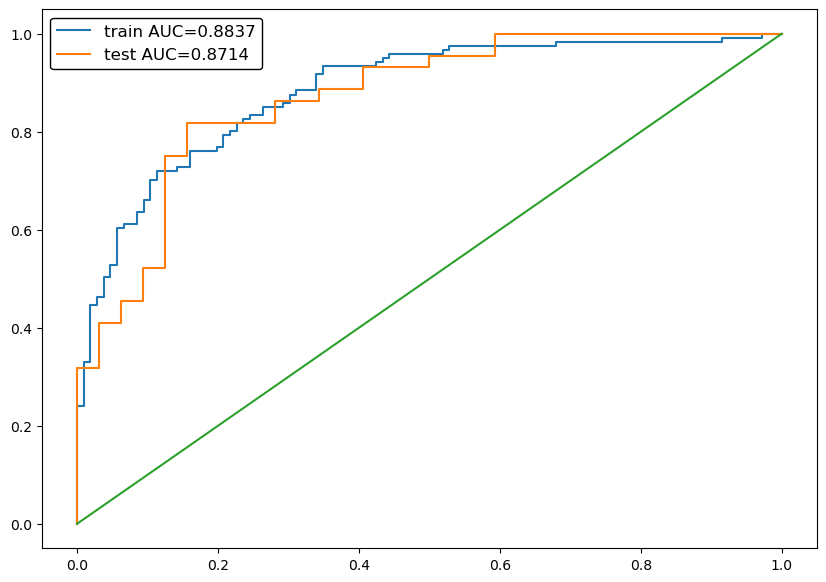

In [69]:
y_test_predicted = grid_search.predict_proba(X_test)[:, 1]
y_train_predicted = grid_search.predict_proba(X_train)[:, 1]
draw_auc_curve(y_train, y_train_predicted, y_test, y_test_predicted) 

# Теперь воспользуемся catboost
(мне он понравился, простой и мощный)

In [70]:
import catboost

In [71]:
X = df[feature_cols]
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, silent=True,
                                             cat_features=cat_cols,
                                             eval_metric='AUC')

params_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.01],
    'depth': [4, 6, 8],
    'l2_leaf_reg': np.linspace(0, 1, 20)
}

boosting_model.grid_search(params_grid, 
                           X_train, 
                           y_train, plot=False, refit=True)

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]


bestTest = 0.8566666667
bestIteration = 35

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8566667	best: 0.8566667 (0)	total: 2.96s	remaining: 14m 46s

bestTest = 0.79
bestIteration = 17

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.7900000	best: 0.8566667 (0)	total: 6.01s	remaining: 14m 56s

bestTest = 0.8175
bestIteration = 7

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.8175000	best: 0.8566667 (0)	total: 8.99s	remaining: 14m 50s

bestTest = 0.8466666667
bestIteration = 6

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.8466667	best: 0.8566667 (0)	total: 11.8s	remaining: 14m 32s

bestTest = 0.79

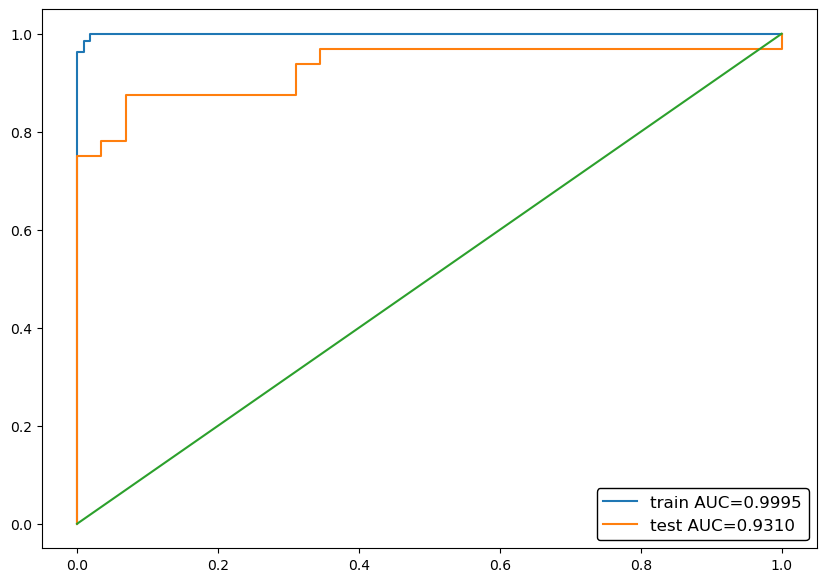

In [74]:
draw_auc_curve(y_train, y_train_predicted, y_test, y_test_predicted)

# DecisionTreeRegressor

In [1]:
from sklearn.tree import DecisionTreeRegressor

In [12]:
pipeline_DT = Pipeline([
    ('preprocessor', preprocessor),          
    ('classifier', DecisionTreeRegressor())     
])

In [17]:
parameters = {
    'classifier__max_depth': [None, 5, 8, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(pipeline_DT, param_grid=parameters, cv=5, scoring='roc_auc')

In [18]:
grid_search.fit(X_train, y_train)

# Вывод результатов GridSearchCV
print("Лучшие параметры: ", grid_search.best_params_)
print("Наилучший результат кросс-валидации (AUC-ROC): ", grid_search.best_score_)

# Оценка модели на тестовом наборе
auc_roc = grid_search.score(X_test, y_test)
print("AUC-ROC на тестовом наборе: ", auc_roc)

Лучшие параметры:  {'classifier__max_depth': None, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}
Наилучший результат кросс-валидации (AUC-ROC):  0.7833326338242864
AUC-ROC на тестовом наборе:  0.8267361111111111


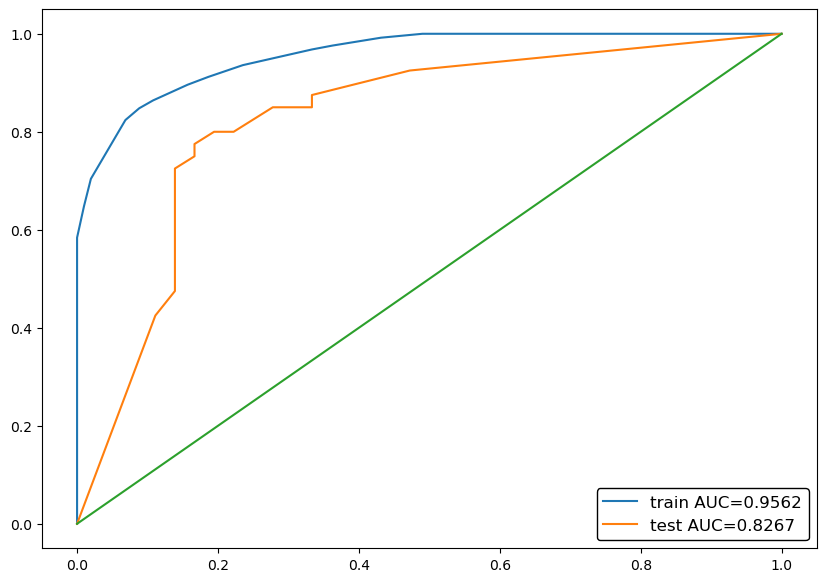

In [24]:
y_test_predicted = grid_search.predict(X_test)#[:, 1]
y_train_predicted = grid_search.predict(X_train)#[:, 1]
draw_auc_curve(y_train, y_train_predicted, y_test, y_test_predicted) 

# SVM
(как я понимаю это только для оинейно разделимых случаев*)
*можно сделать фичи нелинейными

In [27]:
from sklearn.svm import SVC

In [28]:
pipeline_SVM = Pipeline([
    ('preprocessor', preprocessor),          
    ('classifier', SVC())     
])
parameters = {
    'classifier__C': [0.1, 0.2, 0.3, 0.4, 1, 10],
}
grid_search = GridSearchCV(pipeline_SVM, param_grid=parameters, cv=5, scoring='roc_auc')

In [29]:
grid_search.fit(X_train, y_train)

# Вывод результатов GridSearchCV
print("Лучшие параметры: ", grid_search.best_params_)
print("Наилучший результат кросс-валидации (AUC-ROC): ", grid_search.best_score_)

# Оценка модели на тестовом наборе
auc_roc = grid_search.score(X_test, y_test)
print("AUC-ROC на тестовом наборе: ", auc_roc)

Лучшие параметры:  {'classifier__C': 0.1}
Наилучший результат кросс-валидации (AUC-ROC):  0.849942857142857
AUC-ROC на тестовом наборе:  0.775


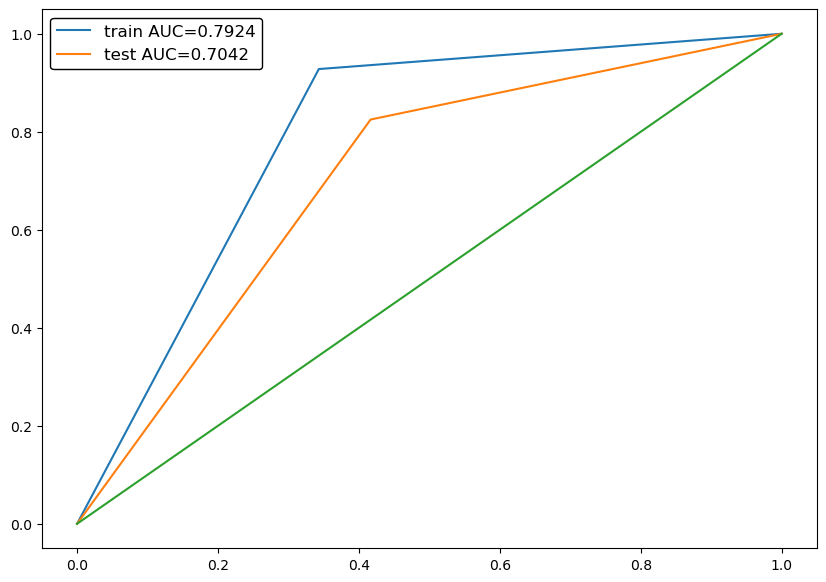

In [30]:
y_test_predicted = grid_search.predict(X_test)#[:, 1]
y_train_predicted = grid_search.predict(X_train)#[:, 1]
draw_auc_curve(y_train, y_train_predicted, y_test, y_test_predicted) 

# My Descision Tree

In [ ]:
class MyDT:
    def __init__(depth = 4, min_samples_leaf = 4):
        self.depth = 4
        self.min_samples_leaf = min_samples_leaf

In [20]:
import numpy as np

class DecisionNode:
    def __init__(self, feature_index=None, threshold=None, value=None, left=None, right=None):
        self.feature_index = feature_index  # Index of the feature used for splitting
        self.threshold = threshold          # Threshold value for splitting
        self.value = value                  # Value to return if the node is a leaf (None for non-leaf nodes)
        self.left = left                    # Left subtree (DecisionNode or leaf value)
        self.right = right                  # Right subtree (DecisionNode or leaf value)

class DecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.tree = None

    def mse(self, y):
        return np.mean((y - np.mean(y)) ** 2)

    def split_dataset(self, X, y, feature_index, threshold):
        left_mask = X[:, feature_index] <= threshold
        right_mask = ~left_mask
        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[right_mask], y[right_mask]
        return X_left, X_right, y_left, y_right

    def find_best_split(self, X, y):
        m, n = X.shape
        best_mse = float('inf')
        best_feature_index, best_threshold = None, None

        if self.random_state is not None:
            np.random.seed(self.random_state)

        # Randomly shuffle the feature indices for random feature selection
        feature_indices = np.random.permutation(n)

        for feature_index in feature_indices:
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                X_left, X_right, y_left, y_right = self.split_dataset(X, y, feature_index, threshold)
                if len(X_left) < self.min_samples_leaf or len(X_right) < self.min_samples_leaf:
                    continue
                mse = len(X_left) / m * self.mse(y_left) + len(X_right) / m * self.mse(y_right)
                if mse < best_mse:
                    best_mse = mse
                    best_feature_index = feature_index
                    best_threshold = threshold

        return best_feature_index, best_threshold

    def build_tree(self, X, y, depth):
        m, n = X.shape

        if depth == self.max_depth or m < self.min_samples_split:
            return DecisionNode(value=np.mean(y))

        feature_index, threshold = self.find_best_split(X, y)

        if feature_index is None:
            return DecisionNode(value=np.mean(y))

        X_left, X_right, y_left, y_right = self.split_dataset(X, y, feature_index, threshold)

        if len(X_left) == 0 or len(X_right) == 0:
            return DecisionNode(value=np.mean(y))

        left_subtree = self.build_tree(X_left, y_left, depth + 1)
        right_subtree = self.build_tree(X_right, y_right, depth + 1)

        return DecisionNode(feature_index=feature_index, threshold=threshold, left=left_subtree, right=right_subtree)

    def fit(self, X, y):
        if len(X) != len(y):
            raise ValueError("Input data and target values must have the same length.")
        
        if len(X) == 0:
            raise ValueError("Input data is empty.")

        self.tree = self.build_tree(X, y, depth=0)

    def _predict_sample(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature_index] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)

    def predict_proba(self, X):
        if self.tree is None:
            raise ValueError("The Decision Tree has not been fitted. Call 'fit' before 'predict'.")

        return np.array([self._predict_sample(x, self.tree) for x in X])

# Example usage of the DecisionTreeRegressor class
X_train = np.array([[1], [2], [3], [4], [5]])
y_train = np.array([2, 4, 3, 5, 6])
X_test = np.array([[6], [7]])


In [21]:
# Создание pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),          
    ('classifier', DecisionTreeRegressor(max_depth=2, min_samples_split=2, min_samples_leaf=1))     
])

In [22]:
X = df[feature_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [23]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict_proba(X_test)
print('test: ',roc_auc_score(y_test, y_pred))

y_pred = pipeline.predict_proba(X_train)
print('train: ',roc_auc_score(y_train, y_pred))

test:  0.7506925207756232
train:  0.8605118110236221
